# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

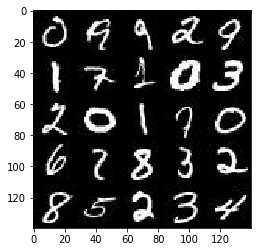

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

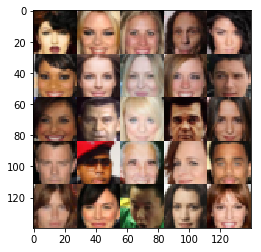

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name="lr")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        relu3_shape = relu3.shape.as_list()
        flat = tf.reshape(relu3, (-1, (relu3_shape[1] * relu3_shape[2] * relu3_shape[3])))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='same') 
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)    
    with tf.control_dependencies(g_update_ops):    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print("Epochs: {} \nBatch Size: {} \nLearning Rate: {} \nBeta1: {} \nData Shape: {}"\
         .format(epoch_count, batch_size, learning_rate, beta1, data_shape))
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_train_loss, g_train_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_train_loss, g_train_loss, learning_rate, beta1)
    
    batch_count = 0
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Get images, reshape and rescale to pass to D
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                feed_dict = {input_real: batch_images, input_z: batch_z}
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict=feed_dict)
                for _ in range(4):
                    _ = sess.run(g_train_opt, feed_dict=feed_dict)
                
                # Print the generator output every 100 batches
                batch_count += 1
                if batch_count % 25 == 0:
                    d_loss, g_loss = sess.run([d_train_loss, g_train_loss], feed_dict)
                    print("Epoch: {}/{}, Batch: {}, Discriminator Loss: {:.3f}, Generator Loss: {:.3f}"\
                          .format(epoch+1, epochs, batch_count, d_loss, g_loss))
                
                if batch_count % 75 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epochs: 2 
Batch Size: 64 
Learning Rate: 0.0002 
Beta1: 0.5 
Data Shape: (60000, 28, 28, 1)
Epoch: 1/2, Batch: 25, Discriminator Loss: 2.840, Generator Loss: 0.156
Epoch: 1/2, Batch: 50, Discriminator Loss: 2.203, Generator Loss: 0.325
Epoch: 1/2, Batch: 75, Discriminator Loss: 1.827, Generator Loss: 0.297


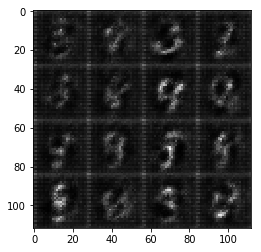

Epoch: 1/2, Batch: 100, Discriminator Loss: 1.856, Generator Loss: 0.269
Epoch: 1/2, Batch: 125, Discriminator Loss: 1.705, Generator Loss: 0.536
Epoch: 1/2, Batch: 150, Discriminator Loss: 1.698, Generator Loss: 0.321


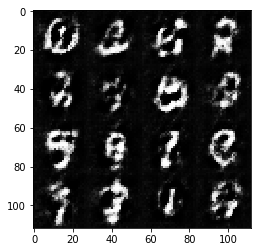

Epoch: 1/2, Batch: 175, Discriminator Loss: 1.460, Generator Loss: 0.788
Epoch: 1/2, Batch: 200, Discriminator Loss: 1.682, Generator Loss: 0.961
Epoch: 1/2, Batch: 225, Discriminator Loss: 1.561, Generator Loss: 0.466


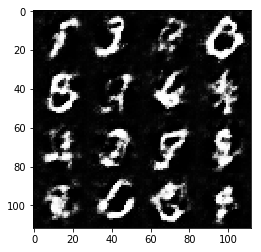

Epoch: 1/2, Batch: 250, Discriminator Loss: 1.670, Generator Loss: 0.390
Epoch: 1/2, Batch: 275, Discriminator Loss: 1.683, Generator Loss: 0.459
Epoch: 1/2, Batch: 300, Discriminator Loss: 1.644, Generator Loss: 0.431


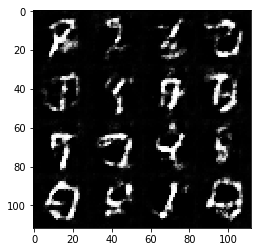

Epoch: 1/2, Batch: 325, Discriminator Loss: 1.815, Generator Loss: 0.770
Epoch: 1/2, Batch: 350, Discriminator Loss: 1.631, Generator Loss: 0.360
Epoch: 1/2, Batch: 375, Discriminator Loss: 1.631, Generator Loss: 0.479


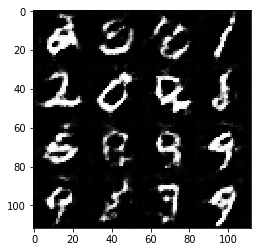

Epoch: 1/2, Batch: 400, Discriminator Loss: 1.716, Generator Loss: 0.391
Epoch: 1/2, Batch: 425, Discriminator Loss: 1.682, Generator Loss: 0.362
Epoch: 1/2, Batch: 450, Discriminator Loss: 1.619, Generator Loss: 0.435


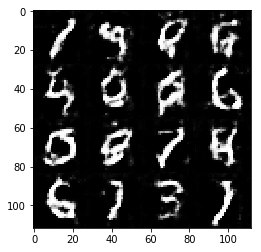

Epoch: 1/2, Batch: 475, Discriminator Loss: 1.645, Generator Loss: 0.423
Epoch: 1/2, Batch: 500, Discriminator Loss: 1.743, Generator Loss: 0.391
Epoch: 1/2, Batch: 525, Discriminator Loss: 1.735, Generator Loss: 0.285


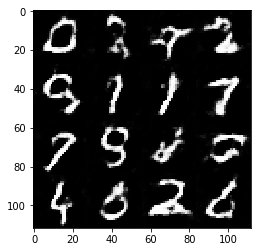

Epoch: 1/2, Batch: 550, Discriminator Loss: 1.747, Generator Loss: 0.841
Epoch: 1/2, Batch: 575, Discriminator Loss: 1.686, Generator Loss: 0.343
Epoch: 1/2, Batch: 600, Discriminator Loss: 1.495, Generator Loss: 0.525


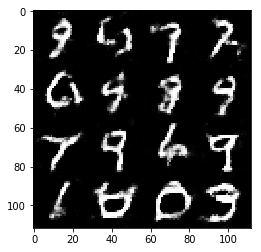

Epoch: 1/2, Batch: 625, Discriminator Loss: 1.658, Generator Loss: 0.469
Epoch: 1/2, Batch: 650, Discriminator Loss: 1.626, Generator Loss: 0.472
Epoch: 1/2, Batch: 675, Discriminator Loss: 1.629, Generator Loss: 0.438


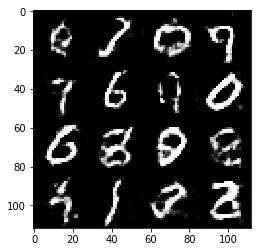

Epoch: 1/2, Batch: 700, Discriminator Loss: 1.720, Generator Loss: 0.740
Epoch: 1/2, Batch: 725, Discriminator Loss: 1.642, Generator Loss: 0.368
Epoch: 1/2, Batch: 750, Discriminator Loss: 1.607, Generator Loss: 0.501


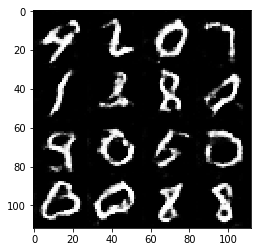

Epoch: 1/2, Batch: 775, Discriminator Loss: 1.607, Generator Loss: 0.679
Epoch: 1/2, Batch: 800, Discriminator Loss: 1.638, Generator Loss: 0.501
Epoch: 1/2, Batch: 825, Discriminator Loss: 1.769, Generator Loss: 0.308


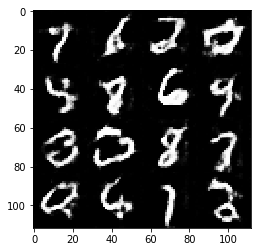

Epoch: 1/2, Batch: 850, Discriminator Loss: 1.804, Generator Loss: 0.253
Epoch: 1/2, Batch: 875, Discriminator Loss: 1.558, Generator Loss: 0.550
Epoch: 1/2, Batch: 900, Discriminator Loss: 1.553, Generator Loss: 0.470


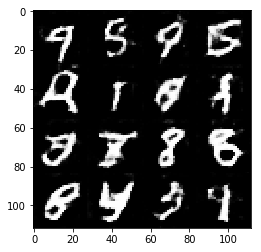

Epoch: 1/2, Batch: 925, Discriminator Loss: 1.501, Generator Loss: 0.552
Epoch: 2/2, Batch: 950, Discriminator Loss: 1.763, Generator Loss: 0.285
Epoch: 2/2, Batch: 975, Discriminator Loss: 1.580, Generator Loss: 0.509


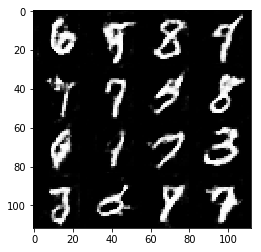

Epoch: 2/2, Batch: 1000, Discriminator Loss: 1.934, Generator Loss: 0.198
Epoch: 2/2, Batch: 1025, Discriminator Loss: 1.616, Generator Loss: 0.673
Epoch: 2/2, Batch: 1050, Discriminator Loss: 1.725, Generator Loss: 0.328


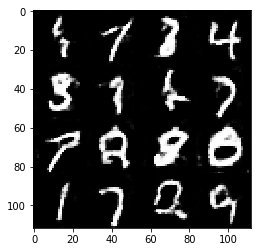

Epoch: 2/2, Batch: 1075, Discriminator Loss: 1.656, Generator Loss: 0.367
Epoch: 2/2, Batch: 1100, Discriminator Loss: 1.675, Generator Loss: 0.584
Epoch: 2/2, Batch: 1125, Discriminator Loss: 1.641, Generator Loss: 0.339


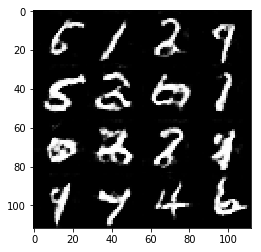

Epoch: 2/2, Batch: 1150, Discriminator Loss: 1.497, Generator Loss: 0.493
Epoch: 2/2, Batch: 1175, Discriminator Loss: 1.545, Generator Loss: 0.464
Epoch: 2/2, Batch: 1200, Discriminator Loss: 1.622, Generator Loss: 0.592


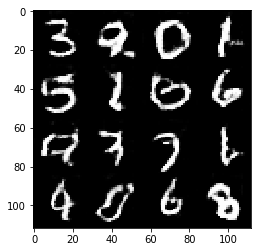

Epoch: 2/2, Batch: 1225, Discriminator Loss: 1.693, Generator Loss: 0.369
Epoch: 2/2, Batch: 1250, Discriminator Loss: 1.569, Generator Loss: 0.397
Epoch: 2/2, Batch: 1275, Discriminator Loss: 1.516, Generator Loss: 0.492


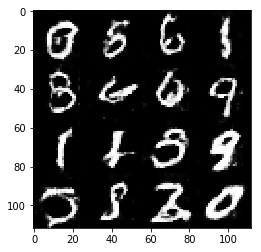

Epoch: 2/2, Batch: 1300, Discriminator Loss: 1.495, Generator Loss: 0.498
Epoch: 2/2, Batch: 1325, Discriminator Loss: 1.918, Generator Loss: 0.211
Epoch: 2/2, Batch: 1350, Discriminator Loss: 1.774, Generator Loss: 0.621


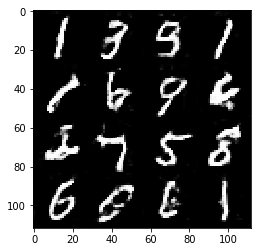

Epoch: 2/2, Batch: 1375, Discriminator Loss: 1.681, Generator Loss: 0.294
Epoch: 2/2, Batch: 1400, Discriminator Loss: 1.605, Generator Loss: 0.481
Epoch: 2/2, Batch: 1425, Discriminator Loss: 1.530, Generator Loss: 0.529


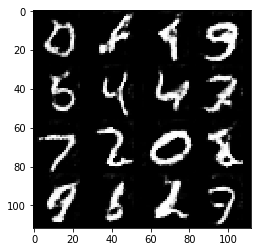

Epoch: 2/2, Batch: 1450, Discriminator Loss: 1.872, Generator Loss: 0.217
Epoch: 2/2, Batch: 1475, Discriminator Loss: 1.561, Generator Loss: 0.492
Epoch: 2/2, Batch: 1500, Discriminator Loss: 1.872, Generator Loss: 0.261


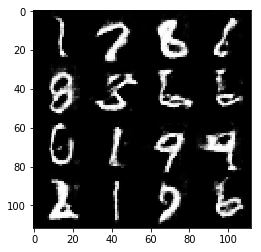

Epoch: 2/2, Batch: 1525, Discriminator Loss: 1.885, Generator Loss: 0.225
Epoch: 2/2, Batch: 1550, Discriminator Loss: 1.471, Generator Loss: 0.472
Epoch: 2/2, Batch: 1575, Discriminator Loss: 1.799, Generator Loss: 0.560


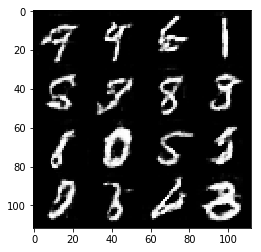

Epoch: 2/2, Batch: 1600, Discriminator Loss: 1.541, Generator Loss: 0.412
Epoch: 2/2, Batch: 1625, Discriminator Loss: 1.939, Generator Loss: 0.201
Epoch: 2/2, Batch: 1650, Discriminator Loss: 1.655, Generator Loss: 0.323


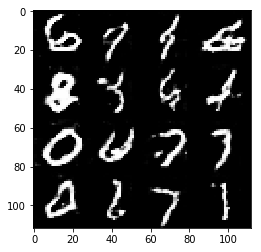

Epoch: 2/2, Batch: 1675, Discriminator Loss: 1.578, Generator Loss: 0.421
Epoch: 2/2, Batch: 1700, Discriminator Loss: 1.613, Generator Loss: 0.362
Epoch: 2/2, Batch: 1725, Discriminator Loss: 1.695, Generator Loss: 0.541


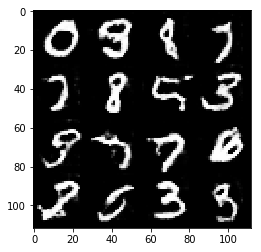

Epoch: 2/2, Batch: 1750, Discriminator Loss: 1.657, Generator Loss: 0.294
Epoch: 2/2, Batch: 1775, Discriminator Loss: 1.696, Generator Loss: 0.283
Epoch: 2/2, Batch: 1800, Discriminator Loss: 1.627, Generator Loss: 0.317


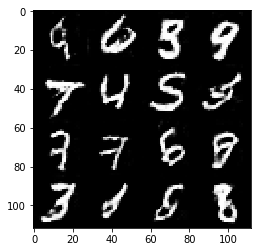

Epoch: 2/2, Batch: 1825, Discriminator Loss: 1.379, Generator Loss: 0.872
Epoch: 2/2, Batch: 1850, Discriminator Loss: 2.407, Generator Loss: 0.818


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epochs: 1 
Batch Size: 64 
Learning Rate: 0.0002 
Beta1: 0.5 
Data Shape: (202599, 28, 28, 3)
Epoch: 1/1, Batch: 25, Discriminator Loss: 4.229, Generator Loss: 0.145
Epoch: 1/1, Batch: 50, Discriminator Loss: 2.487, Generator Loss: 0.292
Epoch: 1/1, Batch: 75, Discriminator Loss: 2.162, Generator Loss: 0.378


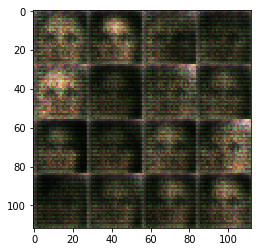

Epoch: 1/1, Batch: 100, Discriminator Loss: 2.000, Generator Loss: 0.424
Epoch: 1/1, Batch: 125, Discriminator Loss: 1.926, Generator Loss: 0.482
Epoch: 1/1, Batch: 150, Discriminator Loss: 1.798, Generator Loss: 0.451


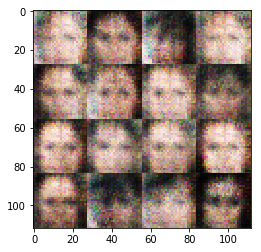

Epoch: 1/1, Batch: 175, Discriminator Loss: 1.972, Generator Loss: 0.411
Epoch: 1/1, Batch: 200, Discriminator Loss: 1.711, Generator Loss: 0.551
Epoch: 1/1, Batch: 225, Discriminator Loss: 1.718, Generator Loss: 0.499


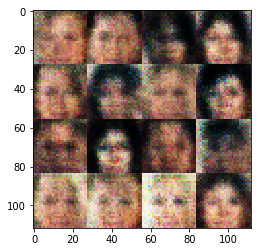

Epoch: 1/1, Batch: 250, Discriminator Loss: 1.723, Generator Loss: 0.498
Epoch: 1/1, Batch: 275, Discriminator Loss: 1.743, Generator Loss: 0.556
Epoch: 1/1, Batch: 300, Discriminator Loss: 1.641, Generator Loss: 0.508


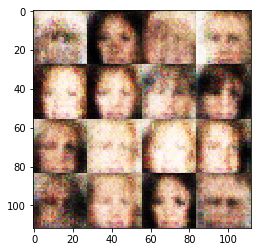

Epoch: 1/1, Batch: 325, Discriminator Loss: 1.574, Generator Loss: 0.580
Epoch: 1/1, Batch: 350, Discriminator Loss: 1.621, Generator Loss: 0.567
Epoch: 1/1, Batch: 375, Discriminator Loss: 1.581, Generator Loss: 0.560


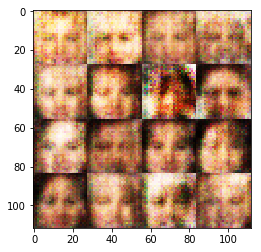

Epoch: 1/1, Batch: 400, Discriminator Loss: 1.554, Generator Loss: 0.630
Epoch: 1/1, Batch: 425, Discriminator Loss: 1.588, Generator Loss: 0.579
Epoch: 1/1, Batch: 450, Discriminator Loss: 1.543, Generator Loss: 0.588


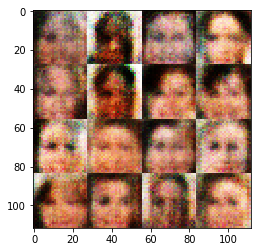

Epoch: 1/1, Batch: 475, Discriminator Loss: 1.571, Generator Loss: 0.578
Epoch: 1/1, Batch: 500, Discriminator Loss: 1.565, Generator Loss: 0.552
Epoch: 1/1, Batch: 525, Discriminator Loss: 1.532, Generator Loss: 0.646


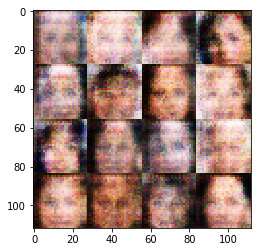

Epoch: 1/1, Batch: 550, Discriminator Loss: 1.532, Generator Loss: 0.592
Epoch: 1/1, Batch: 575, Discriminator Loss: 1.514, Generator Loss: 0.669
Epoch: 1/1, Batch: 600, Discriminator Loss: 1.515, Generator Loss: 0.644


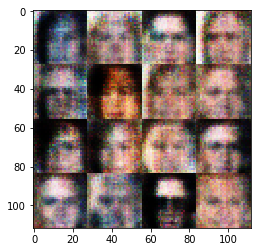

Epoch: 1/1, Batch: 625, Discriminator Loss: 1.521, Generator Loss: 0.573
Epoch: 1/1, Batch: 650, Discriminator Loss: 1.514, Generator Loss: 0.624
Epoch: 1/1, Batch: 675, Discriminator Loss: 1.550, Generator Loss: 0.619


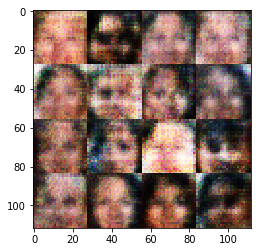

Epoch: 1/1, Batch: 700, Discriminator Loss: 1.489, Generator Loss: 0.638
Epoch: 1/1, Batch: 725, Discriminator Loss: 1.478, Generator Loss: 0.652
Epoch: 1/1, Batch: 750, Discriminator Loss: 1.631, Generator Loss: 0.600


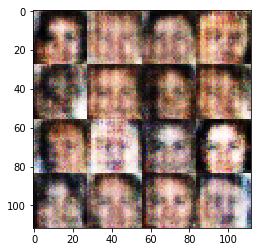

Epoch: 1/1, Batch: 775, Discriminator Loss: 1.491, Generator Loss: 0.564
Epoch: 1/1, Batch: 800, Discriminator Loss: 1.545, Generator Loss: 0.587
Epoch: 1/1, Batch: 825, Discriminator Loss: 1.518, Generator Loss: 0.617


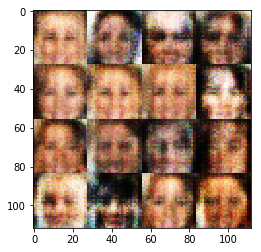

Epoch: 1/1, Batch: 850, Discriminator Loss: 1.541, Generator Loss: 0.582
Epoch: 1/1, Batch: 875, Discriminator Loss: 1.567, Generator Loss: 0.569
Epoch: 1/1, Batch: 900, Discriminator Loss: 1.580, Generator Loss: 0.600


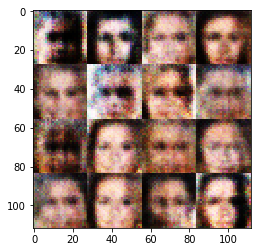

Epoch: 1/1, Batch: 925, Discriminator Loss: 1.560, Generator Loss: 0.613
Epoch: 1/1, Batch: 950, Discriminator Loss: 1.529, Generator Loss: 0.598
Epoch: 1/1, Batch: 975, Discriminator Loss: 1.510, Generator Loss: 0.573


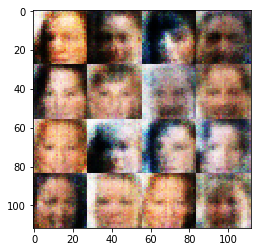

Epoch: 1/1, Batch: 1000, Discriminator Loss: 1.524, Generator Loss: 0.611
Epoch: 1/1, Batch: 1025, Discriminator Loss: 1.525, Generator Loss: 0.616
Epoch: 1/1, Batch: 1050, Discriminator Loss: 1.509, Generator Loss: 0.599


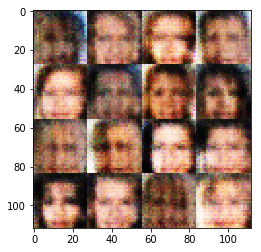

Epoch: 1/1, Batch: 1075, Discriminator Loss: 1.482, Generator Loss: 0.614
Epoch: 1/1, Batch: 1100, Discriminator Loss: 1.488, Generator Loss: 0.651
Epoch: 1/1, Batch: 1125, Discriminator Loss: 1.472, Generator Loss: 0.646


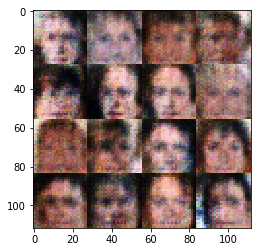

Epoch: 1/1, Batch: 1150, Discriminator Loss: 1.481, Generator Loss: 0.638
Epoch: 1/1, Batch: 1175, Discriminator Loss: 1.519, Generator Loss: 0.609
Epoch: 1/1, Batch: 1200, Discriminator Loss: 1.539, Generator Loss: 0.673


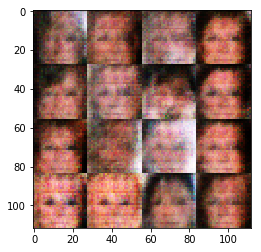

Epoch: 1/1, Batch: 1225, Discriminator Loss: 1.507, Generator Loss: 0.604
Epoch: 1/1, Batch: 1250, Discriminator Loss: 1.445, Generator Loss: 0.687
Epoch: 1/1, Batch: 1275, Discriminator Loss: 1.525, Generator Loss: 0.582


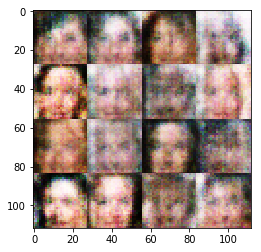

Epoch: 1/1, Batch: 1300, Discriminator Loss: 1.508, Generator Loss: 0.603
Epoch: 1/1, Batch: 1325, Discriminator Loss: 1.442, Generator Loss: 0.600
Epoch: 1/1, Batch: 1350, Discriminator Loss: 1.446, Generator Loss: 0.662


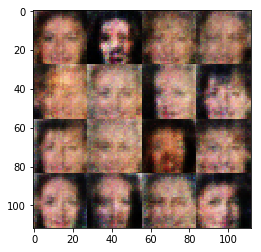

Epoch: 1/1, Batch: 1375, Discriminator Loss: 1.467, Generator Loss: 0.667
Epoch: 1/1, Batch: 1400, Discriminator Loss: 1.451, Generator Loss: 0.656
Epoch: 1/1, Batch: 1425, Discriminator Loss: 1.469, Generator Loss: 0.623


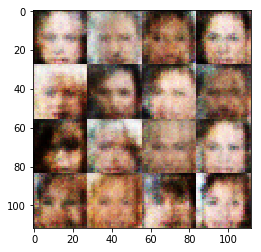

Epoch: 1/1, Batch: 1450, Discriminator Loss: 1.458, Generator Loss: 0.623
Epoch: 1/1, Batch: 1475, Discriminator Loss: 1.445, Generator Loss: 0.682
Epoch: 1/1, Batch: 1500, Discriminator Loss: 1.471, Generator Loss: 0.614


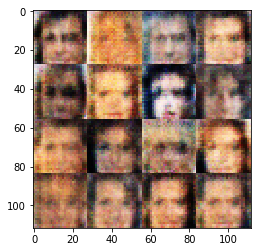

Epoch: 1/1, Batch: 1525, Discriminator Loss: 1.482, Generator Loss: 0.624
Epoch: 1/1, Batch: 1550, Discriminator Loss: 1.470, Generator Loss: 0.621
Epoch: 1/1, Batch: 1575, Discriminator Loss: 1.447, Generator Loss: 0.675


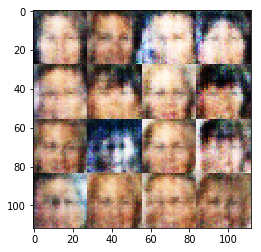

Epoch: 1/1, Batch: 1600, Discriminator Loss: 1.455, Generator Loss: 0.655
Epoch: 1/1, Batch: 1625, Discriminator Loss: 1.474, Generator Loss: 0.615
Epoch: 1/1, Batch: 1650, Discriminator Loss: 1.451, Generator Loss: 0.658


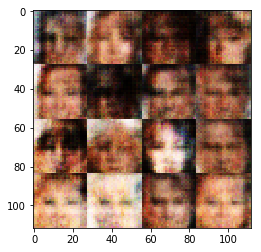

Epoch: 1/1, Batch: 1675, Discriminator Loss: 1.449, Generator Loss: 0.637
Epoch: 1/1, Batch: 1700, Discriminator Loss: 1.450, Generator Loss: 0.666
Epoch: 1/1, Batch: 1725, Discriminator Loss: 1.494, Generator Loss: 0.681


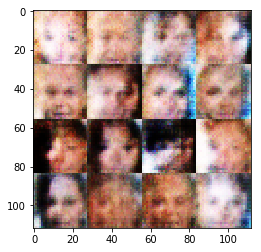

Epoch: 1/1, Batch: 1750, Discriminator Loss: 1.488, Generator Loss: 0.647
Epoch: 1/1, Batch: 1775, Discriminator Loss: 1.491, Generator Loss: 0.626
Epoch: 1/1, Batch: 1800, Discriminator Loss: 1.468, Generator Loss: 0.607


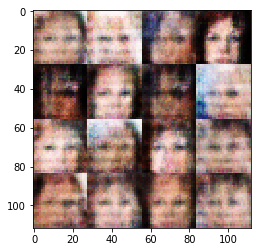

Epoch: 1/1, Batch: 1825, Discriminator Loss: 1.456, Generator Loss: 0.610
Epoch: 1/1, Batch: 1850, Discriminator Loss: 1.496, Generator Loss: 0.675
Epoch: 1/1, Batch: 1875, Discriminator Loss: 1.447, Generator Loss: 0.657


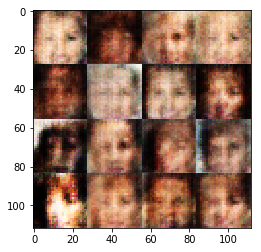

Epoch: 1/1, Batch: 1900, Discriminator Loss: 1.469, Generator Loss: 0.618
Epoch: 1/1, Batch: 1925, Discriminator Loss: 1.451, Generator Loss: 0.620
Epoch: 1/1, Batch: 1950, Discriminator Loss: 1.454, Generator Loss: 0.598


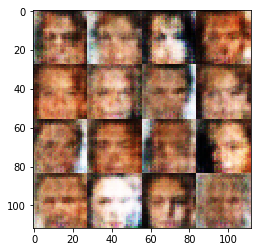

Epoch: 1/1, Batch: 1975, Discriminator Loss: 1.436, Generator Loss: 0.667
Epoch: 1/1, Batch: 2000, Discriminator Loss: 1.456, Generator Loss: 0.665
Epoch: 1/1, Batch: 2025, Discriminator Loss: 1.480, Generator Loss: 0.717


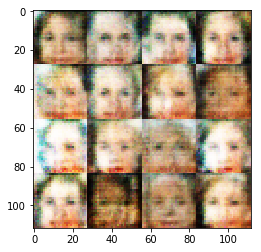

Epoch: 1/1, Batch: 2050, Discriminator Loss: 1.466, Generator Loss: 0.569
Epoch: 1/1, Batch: 2075, Discriminator Loss: 1.482, Generator Loss: 0.627
Epoch: 1/1, Batch: 2100, Discriminator Loss: 1.474, Generator Loss: 0.654


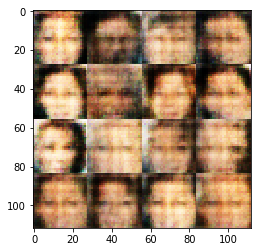

Epoch: 1/1, Batch: 2125, Discriminator Loss: 1.450, Generator Loss: 0.669
Epoch: 1/1, Batch: 2150, Discriminator Loss: 1.424, Generator Loss: 0.713
Epoch: 1/1, Batch: 2175, Discriminator Loss: 1.496, Generator Loss: 0.595


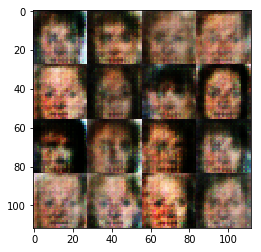

Epoch: 1/1, Batch: 2200, Discriminator Loss: 1.432, Generator Loss: 0.642
Epoch: 1/1, Batch: 2225, Discriminator Loss: 1.447, Generator Loss: 0.674
Epoch: 1/1, Batch: 2250, Discriminator Loss: 1.431, Generator Loss: 0.645


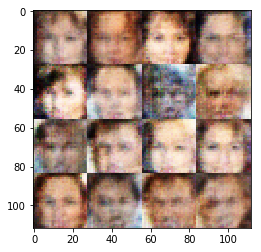

Epoch: 1/1, Batch: 2275, Discriminator Loss: 1.450, Generator Loss: 0.641
Epoch: 1/1, Batch: 2300, Discriminator Loss: 1.449, Generator Loss: 0.669
Epoch: 1/1, Batch: 2325, Discriminator Loss: 1.456, Generator Loss: 0.671


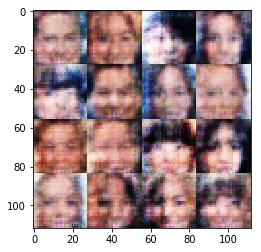

Epoch: 1/1, Batch: 2350, Discriminator Loss: 1.464, Generator Loss: 0.626
Epoch: 1/1, Batch: 2375, Discriminator Loss: 1.441, Generator Loss: 0.630
Epoch: 1/1, Batch: 2400, Discriminator Loss: 1.465, Generator Loss: 0.623


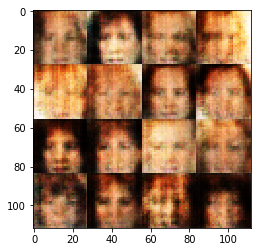

Epoch: 1/1, Batch: 2425, Discriminator Loss: 1.443, Generator Loss: 0.708
Epoch: 1/1, Batch: 2450, Discriminator Loss: 1.430, Generator Loss: 0.650
Epoch: 1/1, Batch: 2475, Discriminator Loss: 1.453, Generator Loss: 0.659


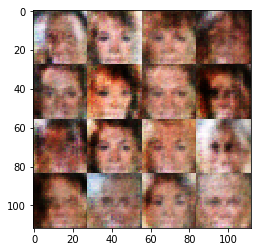

Epoch: 1/1, Batch: 2500, Discriminator Loss: 1.463, Generator Loss: 0.666
Epoch: 1/1, Batch: 2525, Discriminator Loss: 1.459, Generator Loss: 0.679
Epoch: 1/1, Batch: 2550, Discriminator Loss: 1.437, Generator Loss: 0.654


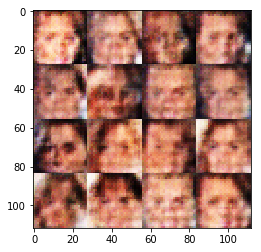

Epoch: 1/1, Batch: 2575, Discriminator Loss: 1.451, Generator Loss: 0.684
Epoch: 1/1, Batch: 2600, Discriminator Loss: 1.454, Generator Loss: 0.642
Epoch: 1/1, Batch: 2625, Discriminator Loss: 1.495, Generator Loss: 0.636


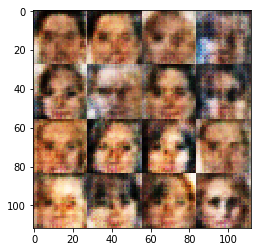

Epoch: 1/1, Batch: 2650, Discriminator Loss: 1.487, Generator Loss: 0.582
Epoch: 1/1, Batch: 2675, Discriminator Loss: 1.434, Generator Loss: 0.695
Epoch: 1/1, Batch: 2700, Discriminator Loss: 1.489, Generator Loss: 0.645


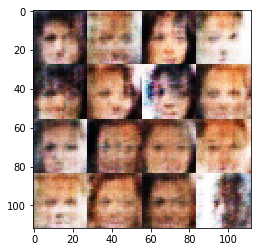

Epoch: 1/1, Batch: 2725, Discriminator Loss: 1.474, Generator Loss: 0.617
Epoch: 1/1, Batch: 2750, Discriminator Loss: 1.488, Generator Loss: 0.640
Epoch: 1/1, Batch: 2775, Discriminator Loss: 1.467, Generator Loss: 0.635


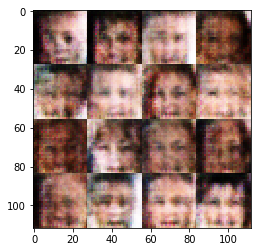

Epoch: 1/1, Batch: 2800, Discriminator Loss: 1.433, Generator Loss: 0.607
Epoch: 1/1, Batch: 2825, Discriminator Loss: 1.456, Generator Loss: 0.596
Epoch: 1/1, Batch: 2850, Discriminator Loss: 1.440, Generator Loss: 0.609


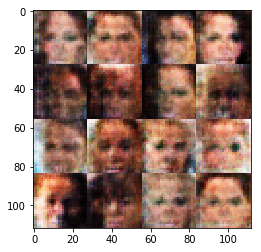

Epoch: 1/1, Batch: 2875, Discriminator Loss: 1.423, Generator Loss: 0.667
Epoch: 1/1, Batch: 2900, Discriminator Loss: 1.431, Generator Loss: 0.667
Epoch: 1/1, Batch: 2925, Discriminator Loss: 1.443, Generator Loss: 0.648


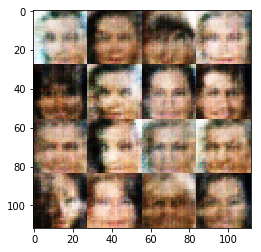

Epoch: 1/1, Batch: 2950, Discriminator Loss: 1.441, Generator Loss: 0.660
Epoch: 1/1, Batch: 2975, Discriminator Loss: 1.454, Generator Loss: 0.639
Epoch: 1/1, Batch: 3000, Discriminator Loss: 1.462, Generator Loss: 0.603


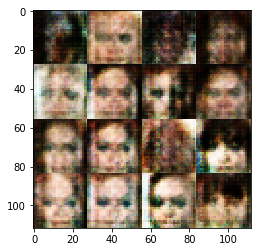

Epoch: 1/1, Batch: 3025, Discriminator Loss: 1.443, Generator Loss: 0.621
Epoch: 1/1, Batch: 3050, Discriminator Loss: 1.469, Generator Loss: 0.660
Epoch: 1/1, Batch: 3075, Discriminator Loss: 1.432, Generator Loss: 0.662


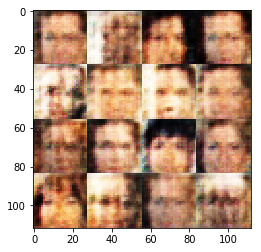

Epoch: 1/1, Batch: 3100, Discriminator Loss: 1.474, Generator Loss: 0.624
Epoch: 1/1, Batch: 3125, Discriminator Loss: 1.468, Generator Loss: 0.612
Epoch: 1/1, Batch: 3150, Discriminator Loss: 1.453, Generator Loss: 0.682


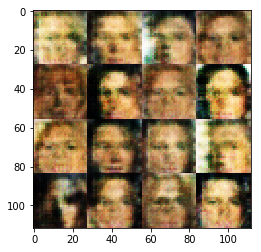

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.